<a href="https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/11_How_to_train_big_arrays_fast_in_tsai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

# Purpose 😇

Interested in speeding up your training on large datasets? 3x?

In this notebook, we'll demonstrate how you can efficiently train a larger-than-memory dataset in **tsai**.


# Import libraries 📚

In [ ]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
# stable = False # True: stable version in pip, False: latest version from github
# if stable: 
#     !pip install tsai -U >> /dev/null
# else:      
#     !pip install git+https://github.com/timeseriesAI/tsai.git -U >> /dev/null
# ## NOTE: REMEMBER TO RESTART (NOT RECONNECT/ RESET) THE KERNEL/ RUNTIME ONCE THE INSTALLATION IS FINISHED

In [ ]:
from tsai.all import *
computer_setup()

os             : Linux
os version     : 5.4.104+
python         : 3.7.11
tsai           : 0.2.20
fastai         : 2.5.2
fastcore       : 1.3.26
torch          : 1.9.0+cu102
n_cpus         : 2
device         : cuda (Tesla K80)


# Zarr arrays ☦️

In addition to tsai, we'll make also need a library called [zarr](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjZ6JD7me3yAhWC2uAKHU6yBdcQFnoECA4QAw&url=https%3A%2F%2Fzarr.readthedocs.io%2F&usg=AOvVaw3MS9C9GsiZ_RRX2IcWe_2w). 


Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. These documents describe the Zarr format and its Python implementation.

**Highlights**

- Create N-dimensional arrays with any NumPy dtype.
- Chunk arrays along any dimension.
- Compress and/or filter chunks using any NumCodecs codec.
- Store arrays in memory, on disk, inside a Zip file, on S3, …
- Read an array concurrently from multiple threads or processes.
- Write to an array concurrently from multiple threads or processes.
- Organize arrays into hierarchies via groups.

In [ ]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE ZARR
# !pip install zarr -U >> /dev/null

In [ ]:
import zarr

## Want to know more about zarr arrays?

We are going to briefly understand how we can use zarr arrays. Let's prepare a relatively small dataset that fits in memory. 

Note: For a more in-depth understanding of zarr arrays you can visit this [tutorial](https://zarr.readthedocs.io/en/stable/tutorial.html).

In [ ]:
path = Path('data')
if not os.path.exists(path): os.makedirs(path)

In [ ]:
arr = np.random.rand(10_000, 10, 100)
np.save(path/'arr.npy', arr)

We know that one of the data formats we can use for large datasets are memory-mapped arrays (np.memmap). They behave like normal arrays, except that they remain on disk. When you index them, only those indices are loaded in memory. That's great because it's what we need to create batches in tsai.

In [ ]:
memmap_arr = np.load(path/'arr.npy', mmap_mode='r+')
memmap_arr.shape

(10000, 10, 100)

### Create an on-disk zarr array & load data

For large datasets, we need to create an zarr array on disk.

In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='w', shape=arr.shape, dtype=arr.dtype)
zarr_arr

<zarr.core.Array (10000, 10, 100) float64>

They are array-like objects, like memmap arrays

In [ ]:
hasattr(memmap_arr, '__array__'), hasattr(zarr_arr, '__array__')

(True, True)

Although they are not np.ndarrays

In [ ]:
isinstance(memmap_arr, np.ndarray), isinstance(zarr_arr, np.ndarray)

(True, False)

To load data we can break it in chunks that fit memory. We can load data from an array, a dataframe, etc. 

In [ ]:
chunksize = 1_000

for i in range(len(memmap_arr) // chunksize + 1):
    zarr_arr[i * chunksize : (i + 1) * chunksize] = memmap_arr[i * chunksize : (i + 1) * chunksize]

Once you load ata, if you want to ensure your data is never modified, you may load the zarr array in mode 'r' (read only). 

Note: there's no need to close zarr arrays.

In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='r')

### How to slice a zarr array?

Let's now create some indices to index the arrays. 

Indexing is used to obtain individual elements from an array. In tsai, it's used to create batches of data by the dataloader. 

In [ ]:
idxs = np.random.choice(len(arr), 64, False)

In [ ]:
arr[idxs].shape, memmap_arr[idxs].shape

((64, 10, 100), (64, 10, 100))

When memmap arrays are index, the index elements become a regular np.array. 

In [ ]:
type(arr[idxs]), type(memmap_arr[idxs])

(numpy.ndarray, numpy.ndarray)

Zarr arrays are unique in the way they need to be indexed.

If we try to apply indices in the same way as with memmap arrays, you'll get an error message.

Zarr arrays have an attribute called 'oindex' that is used to index the array.

In [ ]:
hasattr(zarr_arr, 'oindex')

True

In [ ]:
zarr_arr.oindex[idxs].shape, type(zarr_arr.oindex[idxs])

((64, 10, 100), numpy.ndarray)

In [ ]:
np.array_equal(arr[idxs], memmap_arr[idxs]), np.array_equal(arr[idxs], zarr_arr.oindex[idxs])

(True, True)

tsai supports many types of array-like objects, like numpy arrays, memmap arrays, zarr arrays, xarrays, dask arrays, and even lists or L objects. 

That means you can use any of those types as data inputs. 

# In-memory datasets 🧠

Let's compare the performance of the 3 types of arrays we have created (np.array, np.memmap, zarr). They all fit in memory, although for comparison, np.memmap and zarr data are on disk. 

In [ ]:
%timeit arr[np.random.choice(len(arr), 512, False)]

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.02 ms per loop


In [ ]:
%timeit memmap_arr[np.random.choice(len(arr), 512, False)]

The slowest run took 257.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 2.76 ms per loop


In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='w', shape=arr.shape, dtype=arr.dtype)
zarr_arr, zarr_arr.chunks

(<zarr.core.Array (10000, 10, 100) float64>, (1250, 3, 25))

In [ ]:
%timeit zarr_arr.oindex[np.random.choice(len(arr), 512, False)]

100 loops, best of 5: 16.4 ms per loop


⚠️ In order to improve performance, it's beneficial for zarr arrays to sort the indices. 

In [ ]:
%timeit zarr_arr.oindex[np.sort(np.random.choice(len(arr), 512, False))]

100 loops, best of 5: 8.6 ms per loop


This is very slow!! 🤨

We can use the chunks to make this faster. For an in-depth review on chunks you can read [this](https://docs.dask.org/en/latest/array-chunks.html). 

Best practices are: 

- If you can load the entire array into memory, you can turn off chunks by providing chunks=False, in which case there will be one single chunk for the array.
- If you are only going to index using the 1st dimension, use chunks=(n, -1, -1) which will be faster. You'll need to define n. Later we'll see how to calculate it. 
- Usual chunk size is between 10MB - 1GB. 


⚠️ Note that chunks stands for “chunk shape” rather than “number of chunks”, so specifying chunks=1 means that you will have many chunks, each with exactly one element.

In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='w', shape=arr.shape, dtype=arr.dtype, chunks=(1, -1, -1))
zarr_arr

<zarr.core.Array (10000, 10, 100) float64>

In [ ]:
%timeit zarr_arr.oindex[np.random.choice(len(arr), 512, False)]

10 loops, best of 5: 56.9 ms per loop


In [ ]:
%timeit zarr_arr.oindex[np.sort(np.random.choice(len(arr), 512, False))]

10 loops, best of 5: 35.5 ms per loop


In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='w', shape=arr.shape, dtype=arr.dtype, chunks=(-1, -1, -1))
zarr_arr, zarr_arr.chunks

(<zarr.core.Array (10000, 10, 100) float64>, (10000, 10, 100))

In [ ]:
%timeit zarr_arr.oindex[np.random.choice(len(arr), 512, False)]

100 loops, best of 5: 3.95 ms per loop


In [ ]:
%timeit zarr_arr.oindex[np.sort(np.random.choice(len(arr), 512, False))]

1000 loops, best of 5: 982 µs per loop


We have learned 2 things: 

- For datasets that fit in memory, both numpy arrays and zarr arrays are very fast. Memmap arrays are slower.

- Chunks have a great impact on zarr arrays performance. Always choose chunks=False for datasets that fit in memory. 

⚠️ chunks=False means a single data containing all data in the dataset. We can only do this when data fits in memory. 

# Larger-than-memory datasets 🤯

We are going to create a larger-than_memory file with **dummy data**. 

Colab Pro has 13GB of RAM. The X_large file has 37GB. So we'll need to manage everything on disk.

Data creation will take 1 min.


⚠️ Remember to delete this file when you finish!

In [ ]:
X_large = create_empty_array((1_000_000, 10, 1000), fname='X_large', mode='r+')
del X_large
X_large = np.load(path/'X_large.npy', mmap_mode='r+')
X_large

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
y_large = np.array(['a', 'b', 'c'])[np.random.randint(0, 3, len(X_large))]
np.save(path/'y_large.npy', y_large)
del y_large
y_large = np.load(path/'y_large.npy', mmap_mode='r+')
y_large

memmap(['b', 'a', 'a', ..., 'c', 'a', 'b'], dtype='<U1')

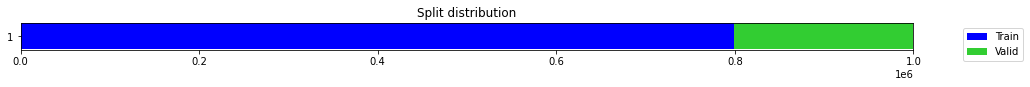

In [ ]:
splits = TimeSplitter()(y_large)

Let's see what's the performance of memmap arrays when they are indexed (simulating a batch creation process): 

In [ ]:
%timeit X_large[np.random.choice(len(X_large), 512, False)]

1 loop, best of 5: 1.41 s per loop


Let's now create a zarr array on disk with the same shape. In this case we are not setting chunks to be able to benchmark performance. 

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype)
X_large_zarr, X_large_zarr.chunks

(<zarr.core.Array (1000000, 10, 1000) float32>, (31250, 1, 63))

In [ ]:
%timeit X_large_zarr.oindex[np.random.choice(len(X_large), 512, False)]

1 loop, best of 5: 517 ms per loop


This is faster (3x on my machine)!!! 

Now we'll apply a better chunking strategy: 

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype, chunks=(1, -1, -1))
X_large_zarr, X_large_zarr.chunks

(<zarr.core.Array (1000000, 10, 1000) float32>, (1, 10, 1000))

In [ ]:
%timeit X_large_zarr.oindex[np.random.choice(len(X_large), 512, False)]

1 loop, best of 5: 211 ms per loop


This is much faster. 7x faster than memmap arrays. 

Let's calculate a chunk of 1GB. There are 37GB in 1_000_000 samples. 

In [ ]:
1_000_000//37

27027

Let's use 25_000 samples per chunk.

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype, chunks=(25_000, -1, -1))
X_large_zarr, X_large_zarr.chunks

(<zarr.core.Array (1000000, 10, 1000) float32>, (25000, 10, 1000))

In [ ]:
%timeit X_large_zarr.oindex[np.random.choice(len(X_large), 512, False)]

10 loops, best of 5: 64.8 ms per loop


Excellent!!! 🙃 I'm starting to really like zarr arrays!!!

One more idea. Zarr arrays are faster when the indices are sorted. Let's try it: 

In [ ]:
%timeit X_large_zarr.oindex[np.sort(np.random.choice(len(X_large), 512, False))]

10 loops, best of 5: 25.9 ms per loop



This is an excellent performance for a large, on-disk dataset like this. It's 50 times faster than memmap arrays!!! 🚀🚀🚀🚀🚀

Zarr arrays are very useful when dealing with larger-then-memory datasets.

There are some important concepts to unsertand why zarr arrays are so fast to index: 

- Chunks are parts of the array that are loaded in memory at the same time. This makes indexing more efficient. 

- Zarr arrays are compressed. This also improves the loading of data in memory. 

- Zarr arrays can be concurrently read and written by multiple threads or processes.

## Key learnings: 

- For datasets that fit in memory, use numpy arrays or np.memmap arrays. 

- For larger than memory datasets, use zarr arrays. 

- Set up chunks=(n, -1, -1)

- To determine the n, a rule of thumb is to calculate the number of samples that fit in 1GB of memory. 

- Sort the indices before indexing the array. 


The tsai library applies all these learnings to achieve the fastest possible performance for larger-than-memory datasets



# Training  🏃🏽‍♀️

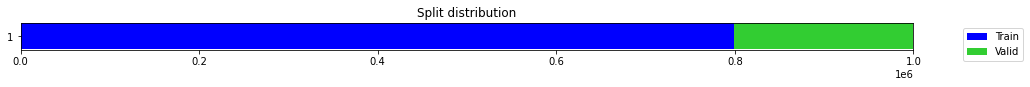

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype, chunks=(25_000, -1, -1))
y_large_zarr = zarr.open(path/'y_large.zarr', mode='w', shape=y_large.shape, dtype=y_large.dtype, chunks=(25_000))
splits = TimeSplitter()(y_large)

When creating the dataloaders, there are 2 important things to remember:

1. If you are dealing with a classification task and need to transform the lavels, use TSClassification. It's vectorized version of Categorize that run much faster.

2. Set inplace to False. This is required when the data doesn't fit in memory. If you don't use it your system will crash and you will need to start again. 

3. Increasing num_workers=cpus may also reduce the training time. 


⚠️ Note: bear in mind we are using dummy data. We are not intereted in accuracy. We are interested in time/epoch.

## np.memmap

epoch,train_loss,valid_loss,accuracy,time
0,1.098610,1.098615,0.333765,47:50


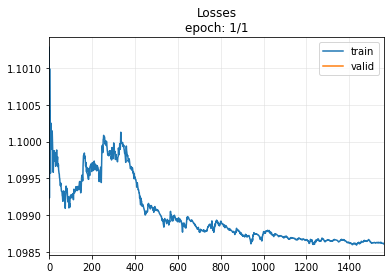

not enough values to plot a chart
Total time        : 0:47:51.242024


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large, y_large, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=cpus)
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

47 minutes / epoch. That's slow!

In this case, GPU utilization is very variable, although a lot of the time stays at 0%. That is because the dataloader takes time to build the batches because indexing is pretty slow with np.memmap arrays with such a large dataset.

## zarr arrays

We'll try first with num_workers=0.

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,16:43


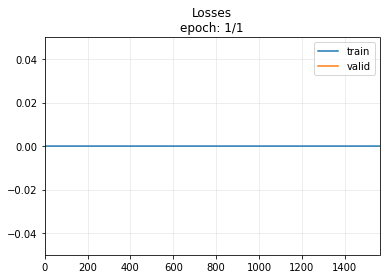

/usr/local/lib/python3.7/dist-packages/tsai/callback/core.py:105: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  if y_bounds is not None: self.graph_ax.set_ylim(*y_bounds)


not enough values to plot a chart
Total time        : 0:16:44.367853


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=0)
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

That's great. An interesting finding is that most of the time the GPU utilization is 100%. This means the batch creation process is no longer a bottleneck. That's why speed is much faster. To further reduce time, we'd need a better GPU and/ or multiple GPUs.

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,16:26


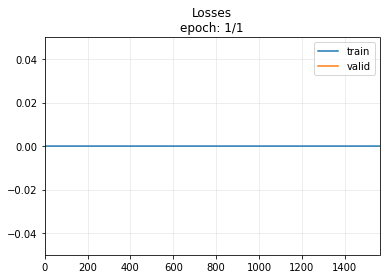

/usr/local/lib/python3.7/dist-packages/tsai/callback/core.py:105: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  if y_bounds is not None: self.graph_ax.set_ylim(*y_bounds)


not enough values to plot a chart
Total time        : 0:16:26.761193


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=cpus) # cpus=4
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

Setting num_workers=cpus didn't help much here probably because the bottleneck is now the GPU. It doesn't matter if the dataloader is faster at generating batches, because the network cannot process them so quickly. I would think that with a more powerful GPU setting num_workers>0 could probably work. 

In any case, the goal is to ensure maximum utilization of your GPU. You can easily get a view of GPU utilization by running this code in your terminal during training: 

```
watch -n .2 nvidia-smi
```

# Conclusion ✅

In this notebook we have learned how we can train a model with a large dataset in tsai. By using zarr arrays and setting the chunks parameter to an optimal value, we can really speed up training 3x!!

Key points: 

- if you dataset fits in memory, use np.arrays or zarr arrays whith chunks = False.
- if your dataset doesn't fit in memory, our recommended format is zarr with chunks = (n, -1, -1)
- the new chunks_calculator in tsai automatically calculates that value. Just use 

   ```
   chunks = chunks_calculator(array.shape, array.dtype)
   ```
- You may also try setting num_workers=cpus, as zarr arrays support parallel computing. This usually improves performance too. 
- By using all this you'll be able to significantly reduce your training time when using out-of-memory datasets. 
- `tsai` currently supports multiple input data types, including: 

   * np.ndarray
   * list
   * L
   * np.memmap
   * dask.array
   * xarray
   * zarr

   The last 4 have the benefit that they can be used on-disk (out-of-core learning), with larger-than-memory datasets.

We hope you've find this tutorial useful. If you have any questions/ issues don't hesitate to visit [tsai](https://github.com/timeseriesAI/tsai) in GitHub!!

# Additional tests

## Chunks benchmark

In [ ]:
for n in np.asarray([1e3, 1e4, 1e5, 1e6], dtype=int):
    shape = (n, 10, 1000)
    dtype = 'float32'
    X_memmap = create_empty_array(shape, fname=f'X_{n}', mode='r+', dtype=dtype)
    X_zarr_default = zarr.open(path/f'X_{n}.zarr', mode='w', shape=shape, dtype=dtype)
    X_zarr_1 = zarr.open(path/f'X_{n}.zarr', mode='w', shape=shape, dtype=dtype, chunks=(1, None, None))
    X_zarr_auto = zarr.open(path/f'X_{n}.zarr', mode='w', shape=shape, dtype=dtype, chunks=chunks_calculator(shape, dtype))
    if n <= 100_000:
        X_zarr_unchunked = zarr.open(path/f'X_{n}.zarr', mode='w', shape=shape, dtype=dtype, chunks=False)
    else: 
        X_zarr_unchunked = None
    
    print(f'\nshape: {shape}')
    for bs in [64, 512]:
        print(f'    batch size: {bs}')
        for name,arr in zip(['memmap', 'zarr_default', 'zarr_1', 'zarr_auto', 'zarr_unchunked'], [X_memmap, X_zarr_default, X_zarr_1, X_zarr_auto, X_zarr_unchunked]):
            if arr is None: continue
            if hasattr(arr, 'oindex'):
                res = %timeit -o -q arr.oindex[np.sort(np.random.choice(len(arr), bs, False))]
            else: 
                res = %timeit -o -q arr[np.sort(np.random.choice(len(arr), bs, False))]
            print(f'        {name:20} chunks: {str(arr.chunks) if hasattr(arr, "chunks") else "N/A":20}: {res.best:10.6f}')


shape: (1000, 10, 1000)
    batch size: 64
        memmap               chunks: N/A                 :   0.000589
        zarr_default         chunks: (250, 3, 250)       :   0.008723
        zarr_1               chunks: (1, 10, 1000)       :   0.015477
        zarr_auto            chunks: (1000, 10, 1000)    :   0.000913
        zarr_unchunked       chunks: (1000, 10, 1000)    :   0.000917
    batch size: 512
        memmap               chunks: N/A                 :   0.020232
        zarr_default         chunks: (250, 3, 250)       :   0.028686
        zarr_1               chunks: (1, 10, 1000)       :   0.137249
        zarr_auto            chunks: (1000, 10, 1000)    :   0.017940
        zarr_unchunked       chunks: (1000, 10, 1000)    :   0.017983

shape: (10000, 10, 1000)
    batch size: 64
        memmap               chunks: N/A                 :   0.000882
        zarr_default         chunks: (1250, 2, 125)      :   0.034200
        zarr_1               chunks: (1, 10, 1000) 

## Dataloader speed

Let's now measure the time it takes the dataloader to create all batches in an epoch.

First, we'll build the dataloaders:

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=(1_000_000, 10, 1000), dtype='float32', chunks=chunks_calculator((1_000_000, 10, 1000), 'float32'))
X_large_zarr, X_large_zarr.chunks

(<zarr.core.Array (1000000, 10, 1000) float32>, (27028, 10, 1000))

In [ ]:
y_large = np.array(['a', 'b', 'c'])[np.random.randint(0, 3, 1_000_000)]
np.save(path/'y_large.npy', y_large)
del y_large
y_large = np.load(path/'y_large.npy', mmap_mode='r+')
y_large_zarr = zarr.open(path/'y_large.zarr', mode='w', shape=y_large.shape, dtype=y_large.dtype, chunks=chunks_calculator(y_large.shape, y_large.dtype))
y_large_zarr, y_large_zarr.chunks

(<zarr.core.Array (1000000,) <U1>, (1000000,))

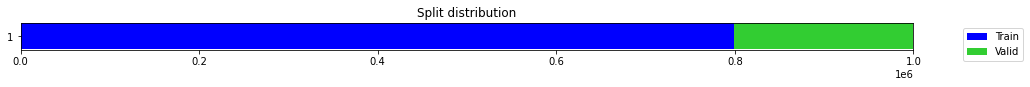

In [ ]:
splits = TimeSplitter()(y_large_zarr)

In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024])
train_dl = dls.train
valid_dl = dls.valid

In [ ]:
timer.start()
for _ in train_dl: _
timer.stop()

Total time        : 0:00:47.665007


In [ ]:
timer.start()
for _ in valid_dl: _
timer.stop()

Total time        : 0:00:06.226197


It takes the dataloader <1 minute to  generate all batches in an epoch. That means that most of the time is spend on the GPU once the batches are passed to the model. 